## Load Libraries

In [25]:
import numpy as np
import pandas as pd
import vaex

## For All States
* Gather county, population information
* Gather covid, county information
* Calculate crashes per 100K Capita
* Calculate covid per 100K Capita
* Compare: 
    * Apr2019 - December2019
    * Apr2020 - December2020
* Did things change? 

In [27]:
covid_df = pd.read_csv('C:/Users/Daniel/Documents/Excel/covid_confirmed_usafacts.csv')
pop_df = pd.read_csv('C:/Users/Daniel/Documents/Excel/covid_county_population.csv', engine='python')

In [83]:
# select the id columns
id_vars = covid_df.columns[:4]
# select only the date columns
value_vars = covid_df.columns[4:]
# melt the covid data
covid_melt_df = pd.melt(covid_df, id_vars=id_vars, value_vars=value_vars)
# find new cases by sorting
covid_melt_df = covid_melt_df.sort_values(by=['countyFIPS','variable'])
# then grouping and subtracting each successive date from the next
covid_melt_df['new_cases'] = covid_melt_df.groupby(['countyFIPS'])['value'].diff().fillna(0)
# merge the covid data with the population data
usafacts_data = pd.merge(
    left=covid_melt_df, 
    right=pop_df[['countyFIPS','State','population']],
    how="left",
    on=['countyFIPS','State']
)
# remove 'statewide unallocated' from County Name
usafacts_data = usafacts_data.drop(usafacts_data[usafacts_data['County Name'] == 'Statewide Unallocated'].index)
# drop StateFIPS, value
usafacts_data = usafacts_data.drop(['countyFIPS','StateFIPS','value'],axis=1)
# rename variable to 'covid_date'
usafacts_data = usafacts_data.rename(columns={'variable':'covid_date'})
# create a county variable without the word 'county'
usafacts_data['County'] = usafacts_data['County Name'].str.split(' ',expand=True)[0]

In [180]:
# load crash data into dataframe
crashes_df = pd.read_csv('C:/Users/Daniel/Documents/Excel/US_Accidents_Dec20.csv')
# convert start_time to datetime and save date component into new column
crashes_df['Start_Date'] = crashes_df['Start_Time'].astype("datetime64[ns]").dt.date
# drop old county name column
usafacts_data = usafacts_data.drop(columns='County Name')

## Join Data

In [238]:
crashes_df['Year'] = pd.DatetimeIndex(crashes_df['Start_Date']).year
crashes_df['Month'] = pd.DatetimeIndex(crashes_df['Start_Date']).month
crashes_df['Day'] = pd.DatetimeIndex(crashes_df['Start_Date']).day

In [239]:
usafacts_data['Year'] = pd.DatetimeIndex(usafacts_data['covid_date']).year
usafacts_data['Month'] = pd.DatetimeIndex(usafacts_data['covid_date']).month
usafacts_data['Day'] = pd.DatetimeIndex(usafacts_data['covid_date']).day

In [240]:
merge_df = pd.merge(
    left=usafacts_data, 
    right=crashes_df,
    how="right",
    left_on=['County','State','Year', 'Month', 'Day'],
    right_on=['County','State','Year', 'Month', 'Day']
)

## Basic description of data

In [242]:
merge_df.dtypes

State                     object
covid_date                object
new_cases                float64
population               float64
County                    object
Year                       int64
Month                      int64
Day                        int64
ID                        object
Source                    object
TMC                      float64
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill

 ## Which Counties experienced the largest increase/decline in crashes after the pandemic?
 * A => beginning to March 11th, 2020
 * B => March 12th, 2020 - December 2020
 * For A, B calculate crashes per capita ( crashes_per_100K )
     * calculate difference between A_crashes_per_100K and B_crashes_per_100K ( for each County )
     * list counties with biggest increases
     * list counties with biggest declines

In [246]:
merge_df['Start_Time'] = merge_df.Start_Date.astype('datetime64[ns]')

In [309]:
merge_df = merge_df[ ( merge_df['Start_Time'] > '2019-03-11 23:59:59' ) & ( merge_df['Start_Time'] < '2021-01-01 00:00:00') ]

In [310]:
merge_df['Interval'] = np.where(merge_df['Start_Time'] < '2020-03-11 23:59:59', 'Pre', 'Post')

c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [314]:
merge_df[merge_df['Interval'] == 'Pre' ]['Start_Time'].min()

Timestamp('2019-03-12 00:00:00')

In [312]:
subset_df = merge_df[['Interval', 'State','County','ID']].drop_duplicates()
crash_count_df = subset_df.groupby(['Interval','State','County']).agg({'ID':'count'})

In [315]:
crash_count_df

ID
Interval State County         
Post     AL    Autauga     276
               Baldwin     453
               Barbour      36
               Bibb         16
               Blount      545
...                        ...
Pre      WY    Platte        4
               Sheridan      1
               Sweetwater    9
               Teton         1
               Uinta         2

[4746 rows x 1 columns]

In [316]:
pop_df = merge_df[['Interval','State','County','population']].drop_duplicates()

In [317]:
crashes_per_capita = pd.merge(
    left=crash_count_df, 
    right=pop_df,
    how="left",
    left_on=['Interval','State','County'],
    right_on=['Interval','State','County']
)

In [318]:
# drop rows with NaN
crashes_per_capita = crashes_per_capita.dropna()

In [319]:
blah = crashes_per_capita.copy()
blah['per_capita'] = ( crashes_per_capita.loc[:, 'ID'] / crashes_per_capita.loc[:, 'population'] ) * 100000

In [324]:
blah2 = blah.pivot_table(index=['State','County'],columns='Interval',values='per_capita',fill_value=0).reset_index()
blah2['Difference'] = blah2['Post'] - blah2['Pre']

In [325]:
blah2[ blah2['Pre'] > 0].sort_values('Difference',ascending=False).head(20)

Interval,State,County,Post,Pre,Difference
804,LA,Orleans,1604.279446,250.164042,1354.115404
178,CA,Trinity,2490.842491,1343.101343,1147.741148
280,FL,Miami-Dade,1490.905210,396.365028,1094.540181
1559,OR,Baker,4502.604813,3448.275862,1054.328951
269,FL,Jefferson,1235.434508,182.507370,1052.927137
2032,VA,Rockbridge,1723.297745,686.661055,1036.636690
172,CA,Siskiyou,1669.767335,672.959875,996.807460
1987,VA,Chesterfield,1221.081513,301.302147,919.779366
444,IA,Adair,1300.335570,475.391499,824.944072
154,CA,Lassen,1409.740621,621.463383,788.277238


In [326]:
blah2[ blah2['Pre'] > 0].sort_values('Difference',ascending=True).head(20)

Interval,State,County,Post,Pre,Difference
1569,OR,Gilliam,8054.393305,12395.397490,-4341.004184
1592,OR,Wheeler,6381.381381,9459.459459,-3078.078078
1949,UT,Garfield,831.518511,3741.833300,-2910.314789
1945,UT,Daggett,1157.894737,4000.000000,-2842.105263
1966,UT,Wayne,405.754334,2213.205459,-1807.451125
1576,OR,Lake,2655.991867,4130.130893,-1474.139027
1379,NV,Esmeralda,687.285223,2061.855670,-1374.570447
1570,OR,Grant,3861.647451,5139.602723,-1277.955272
1956,UT,Piute,608.519270,1690.331305,-1081.812035
1960,UT,Summit,856.566615,1931.427216,-1074.860600


In [329]:
blah2[blah2['County'] == 'Travis']

Interval,State,County,Post,Pre,Difference
1925,TX,Travis,819.181854,1398.637627,-579.455773


## Use causalimpact (python version) to examine impact of covid19 on crash rate

In [364]:
subset_df = merge_df[['Interval', 'State','County','ID','Start_Time']].drop_duplicates()
crash_day_count_df = subset_df.groupby(['Interval','Start_Time']).agg({'ID':'count'})

In [342]:
pop_day_df = merge_df[['State','County','population']].drop_duplicates()
population = pop_day_df['population'].sum()

In [357]:
crash_day_count_df['per_capita'] = ( crash_day_count_df['ID'] / population ) * 100000

In [365]:
crash_day_count_df = crash_day_count_df.sort_values('Start_Time')

In [366]:
crash_day_count_df = crash_day_count_df.reset_index()

In [367]:
crash_day_count_df['index'] = crash_day_count_df.index

In [368]:
crash_day_count_df[crash_day_count_df['Interval'] == 'Post']

,Interval,Start_Time,ID,index
366,Post,2020-03-12,3585,366
367,Post,2020-03-13,3540,367
368,Post,2020-03-14,2052,368
369,Post,2020-03-15,1428,369
370,Post,2020-03-16,2961,370
...,...,...,...,...
656,Post,2020-12-27,5249,656
657,Post,2020-12-28,9189,657
658,Post,2020-12-29,8627,658
659,Post,2020-12-30,9925,659


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3558.0             1049611.0
Prediction (s.d.)         3455.51 (194.51)   1019375.04 (57379.25)
95% CI                    [3067.11, 3829.56] [904797.74, 1129720.27]

Absolute effect (s.d.)    102.49 (194.51)    30235.96 (57379.25)
95% CI                    [-271.56, 490.89]  [-80109.27, 144813.26]

Relative effect (s.d.)    2.97% (5.63%)      2.97% (5.63%)
95% CI                    [-7.86%, 14.21%]   [-7.86%, 14.21%]

Posterior tail-area probability p: 0.27
Posterior prob. of a causal effect: 72.63%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 3558.0. In the absence of an
intervention, we would have expected an average response of 3455.51.
The 95% interval of this counterfactual prediction is [3067.11, 3829.56].
Subtracting th

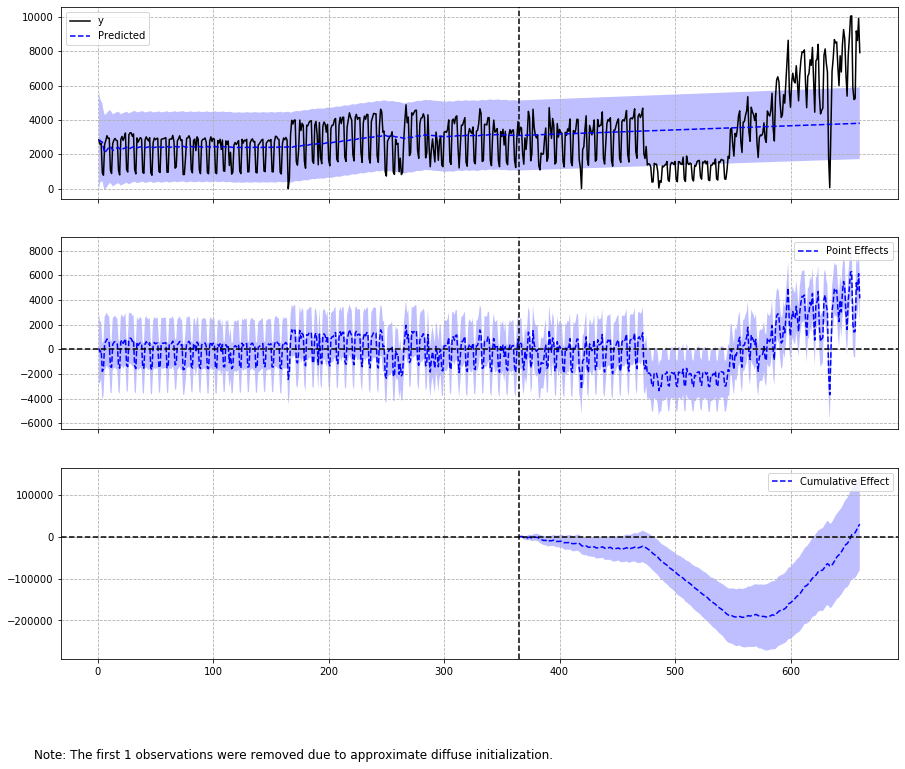

In [369]:
data = crash_day_count_df[['ID','index']].copy()
pre_period = [0, 365]
post_period = [366, 660]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

## Predict number of crashes, use SHAP